2024-12-25 16:36:27,167 - INFO - Using device: cpu
2024-12-25 16:36:27,171 - INFO - Loading dataset from directory: /Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals
2024-12-25 16:36:27,192 - INFO - Loaded 2880 samples.
2024-12-25 16:36:27,193 - INFO - Custom Gym Environment initialized.
2024-12-25 16:36:27,201 - INFO - Quantum Policy Network and Optimizer initialized.
2024-12-25 16:36:27,201 - INFO - Quantum Reinforcement Learning Agent initialized.
2024-12-25 16:36:27,201 - INFO - Starting Training...
Training Episodes: 100%|██████████| 3/3 [01:09<00:00, 23.22s/it]
2024-12-25 16:37:36,922 - INFO - Training Completed.
2024-12-25 16:37:36,923 - INFO - Number of training episodes: 3


Number of training episodes: 3


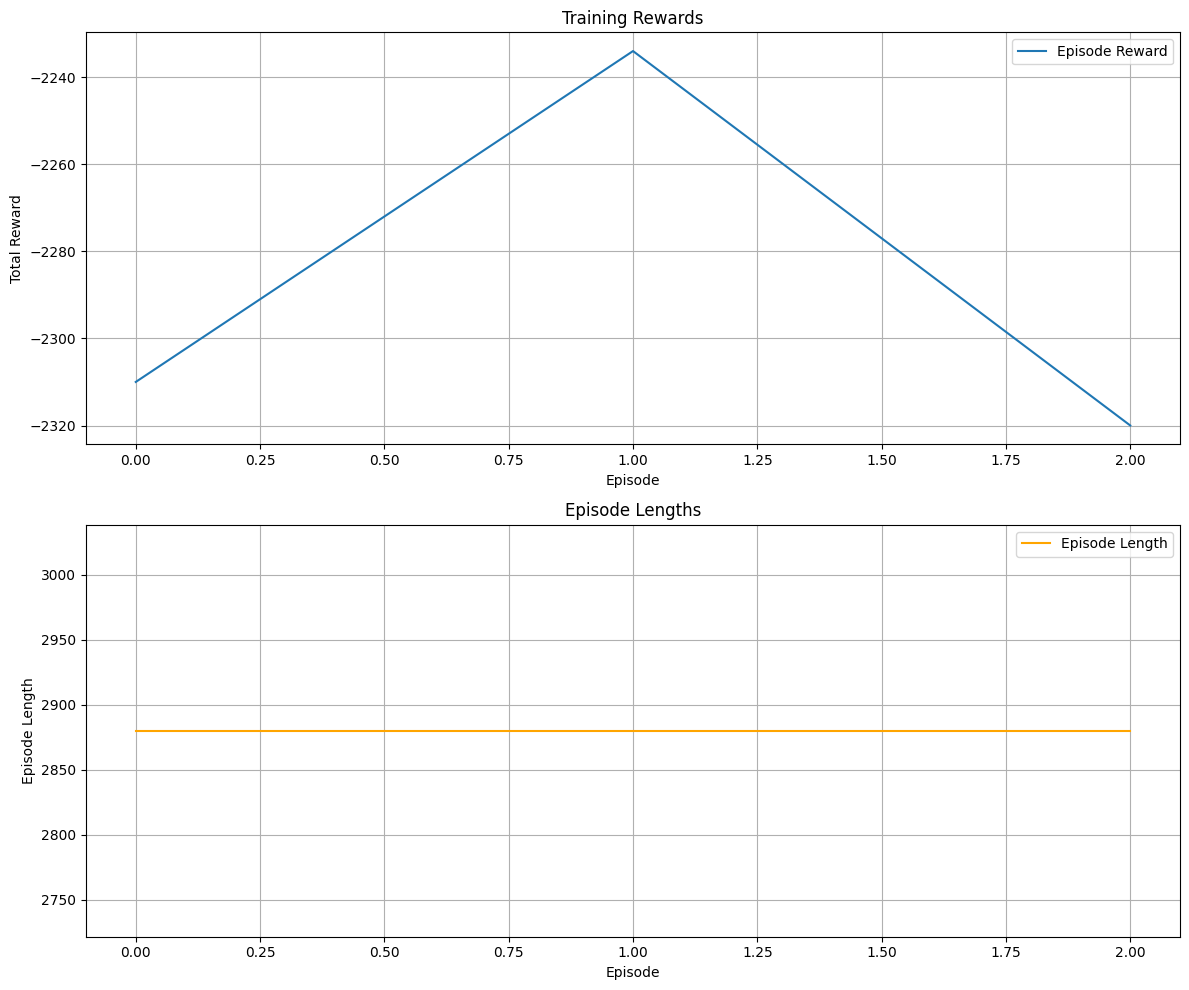

2024-12-25 16:37:37,151 - WARNING - Number of episodes (3) is less than window_size (50). Skipping moving average plots.


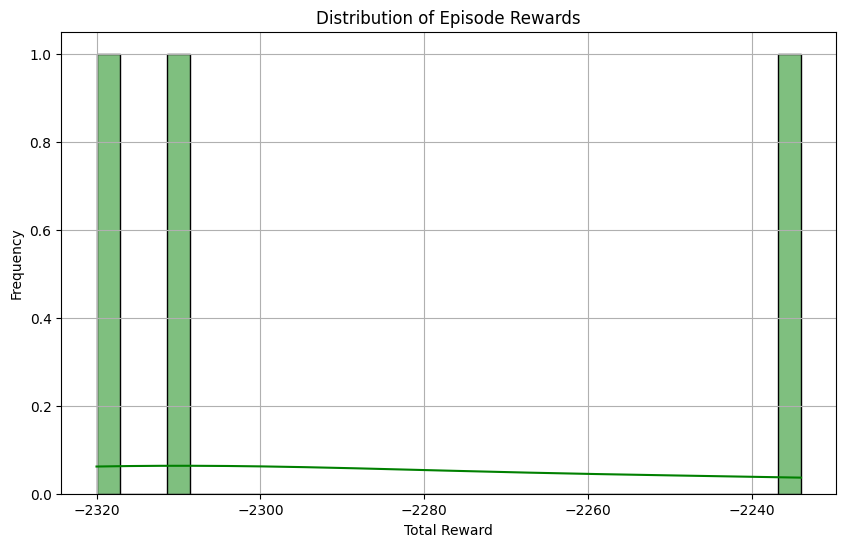

2024-12-25 16:37:37,446 - WARNING - Number of episodes (3) is less than window_size (50). Skipping moving average reward plot.
2024-12-25 16:37:37,449 - INFO - Evaluating the trained agent...
Evaluating Agent: 100%|██████████| 3/3 [01:23<00:00, 27.99s/it]
2024-12-25 16:39:01,417 - INFO - Average Reward over 3 episodes: -2282.00
2024-12-25 16:39:01,425 - INFO - Classification Accuracy: 10.38%
2024-12-25 16:39:01,446 - INFO - Confusion Matrix:
2024-12-25 16:39:01,447 - INFO - 
[[148  67  93  96  57 100  95  67  70  71]
 [154  57 100  87  72 101  84  69  68  72]
 [157  52 114  72  70  94  94  69  75  67]
 [133  61 109  97  65 101  91  60  82  65]
 [132  43 109  88  73 120  89  63  74  73]
 [142  48 116  82  79  95  94  66  74  68]
 [128  54 118  80  64 105  88  73  82  72]
 [144  52 121  90  72  85 106  58  69  67]
 [150  40 116  92  67  74 118  59  81  67]
 [124  58 106  68  71 110  95  75  71  86]]
2024-12-25 16:39:01,447 - INFO - Classification Report:
2024-12-25 16:39:01,447 - INFO - 

Average Reward over 3 episodes: -2282.00
Classification Accuracy: 10.38%
Confusion Matrix:
[[148  67  93  96  57 100  95  67  70  71]
 [154  57 100  87  72 101  84  69  68  72]
 [157  52 114  72  70  94  94  69  75  67]
 [133  61 109  97  65 101  91  60  82  65]
 [132  43 109  88  73 120  89  63  74  73]
 [142  48 116  82  79  95  94  66  74  68]
 [128  54 118  80  64 105  88  73  82  72]
 [144  52 121  90  72  85 106  58  69  67]
 [150  40 116  92  67  74 118  59  81  67]
 [124  58 106  68  71 110  95  75  71  86]]
Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.17      0.13       864
           1       0.11      0.07      0.08       864
           2       0.10      0.13      0.12       864
           3       0.11      0.11      0.11       864
           4       0.11      0.08      0.09       864
           5       0.10      0.11      0.10       864
           6       0.09      0.10      0.10       864
           7       0.0

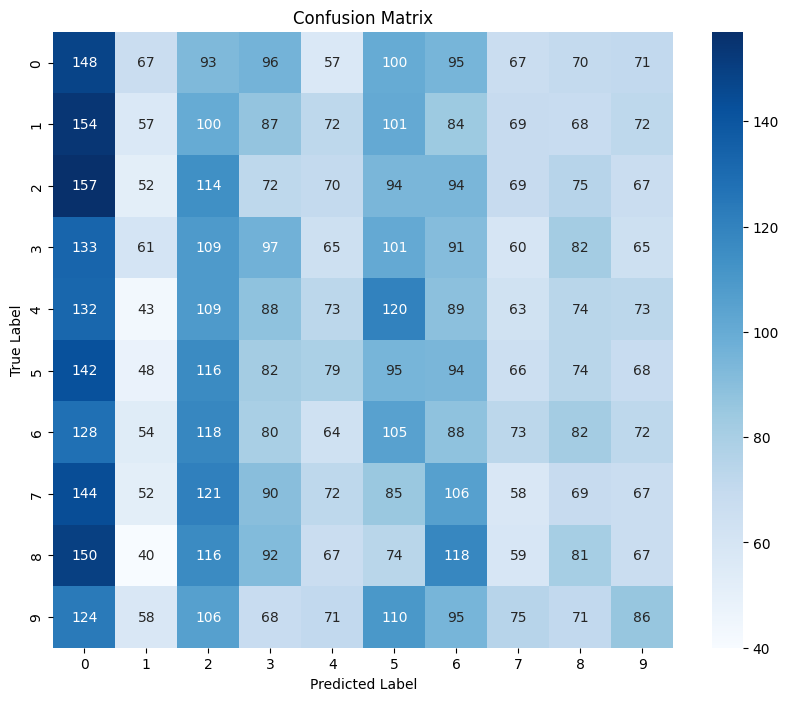

2024-12-25 16:39:01,646 - INFO - Average Reward over 100 episodes: -2282.00


In [16]:
# quantum_reinforcement_learning.py

"""
Quantum Reinforcement Learning (QRL) Agent for Nepali MNIST Classification.

This script defines a custom Gym environment for MNIST classification, a hybrid
quantum-classical policy network using PennyLane and PyTorch, and trains the agent
using the REINFORCE algorithm. It also includes evaluation metrics and visualization
tools to assess the agent's performance.

Directory Structure:
your_project/
├── quantum_reinforcement_learning.py
└── data/
    └── numerals/
        ├── 0/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        ├── 1/
        │   ├── image1.png
        │   ├── image2.png
        │   └── ...
        └── ...
        └── 9/
            ├── image1.png
            ├── image2.png
            └── ...
"""

import os
import logging
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pennylane as qml
import random
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from gym import spaces
from torch.distributions import Categorical
from tqdm import tqdm
import warnings

# ==============================
# Reproducibility
# ==============================
def set_random_seeds(seed=42):
    """
    Sets random seeds for reproducibility.
    Args:
        seed (int): The seed value to use.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

# ==============================
# Logging Setup
# ==============================
def setup_logging(log_file='training.log'):
    """
    Sets up logging for the QRL Agent.
    Args:
        log_file (str): Path to the log file.
    Returns:
        logging.Logger: Configured logger.
    """
    logger = logging.getLogger('QRLAgent')
    logger.setLevel(logging.INFO)

    # Create handlers
    c_handler = logging.StreamHandler()
    f_handler = logging.FileHandler(log_file, mode='w')

    c_handler.setLevel(logging.INFO)
    f_handler.setLevel(logging.INFO)

    # Create formatter and add to handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    c_handler.setFormatter(formatter)
    f_handler.setFormatter(formatter)

    # Add handlers to logger (avoid attaching multiple handlers if re-run)
    if not logger.handlers:
        logger.addHandler(c_handler)
        logger.addHandler(f_handler)

    return logger

logger = setup_logging()

# ==============================
# Custom Gym Environment Definition
# ==============================
class MNISTClassificationEnv(gym.Env):
    """
    Custom Environment for MNIST Classification using Gym interface.
    Each episode presents an image to the agent, and the agent must classify it.
    """
    metadata = {'render.modes': ['human']}
    
    def __init__(self, root_dir, transform=None):
        super(MNISTClassificationEnv, self).__init__()
        
        # Define action and observation space
        # They must be gym.spaces objects
        # Action space: 10 possible actions (digits 0-9)
        self.action_space = spaces.Discrete(10)
        
        # Observation space: 28x28 grayscale images
        self.observation_space = spaces.Box(low=0, high=1, shape=(28,28), dtype=np.float32)
        
        # Load dataset
        self.root_dir = root_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.images = []
        self.labels = []
        
        logger.info(f"Loading dataset from directory: {root_dir}")
        for label in range(10):
            label_dir = os.path.join(root_dir, str(label))
            if not os.path.isdir(label_dir):
                logger.warning(f"Directory for label {label} does not exist: {label_dir}")
                continue
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.images.append(img_path)
                    self.labels.append(label)
        logger.info(f"Loaded {len(self.images)} samples.")
        self.load_dataset()
    
    def load_dataset(self):
        """
        Loads the dataset into memory for faster access.
        """
        self.dataset = list(zip(self.images, self.labels))
        random.shuffle(self.dataset)
    
    def reset(self, seed=None):
        """
        Resets the environment to the initial state and returns the first image.
        """
        if seed is not None:
            self.seed(seed)
        self.current_index = 0
        img_path, label = self.dataset[self.current_index]
        image = Image.open(img_path).convert('L')  # Grayscale
        image = self.transform(image).squeeze().numpy()  # Shape: (28,28)
        return image, {}
    
    def step(self, action):
        """
        Executes one time step within the environment.
        
        Args:
            action (int): The action taken by the agent (predicted digit).
        
        Returns:
            observation (object): Next state (image).
            reward (float): Reward received after taking the action.
            done (bool): Whether the episode has ended.
            info (dict): Additional information.
        """
        img_path, true_label = self.dataset[self.current_index]
        correct = (action == true_label)
        reward = 1.0 if correct else -1.0
        
        # Move to next image
        self.current_index += 1
        done = self.current_index >= len(self.dataset)
        
        if not done:
            next_img_path, next_label = self.dataset[self.current_index]
            image = Image.open(next_img_path).convert('L')  # Grayscale
            image = self.transform(image).squeeze().numpy()  # Shape: (28,28)
        else:
            image = np.zeros((28,28), dtype=np.float32)
        
        return image, reward, done, {'true_label': true_label}
    
    def render(self, mode='human'):
        """
        Renders the current state.
        """
        pass  # For simplicity, rendering is not implemented
    
    def seed(self, seed=None):
        """
        Sets the seed for this environment's random number generator(s).
        """
        random.seed(seed)
        np.random.seed(seed)

# ==============================
# Quantum Policy Network Definition
# ==============================
class QuantumPolicyNetwork(nn.Module):
    """
    Hybrid Quantum-Classical Policy Network for Reinforcement Learning.
    Utilizes a parameterized quantum circuit to process input features.
    """
    def __init__(self, n_qubits=8, n_layers=1, verbose=False):
        super(QuantumPolicyNetwork, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.verbose = verbose
        
        # Define a PennyLane device
        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        
        # Define the quantum circuit as a QNode
        def circuit(weights, x):
            # Encode the classical data into quantum states
            for i in range(self.n_qubits):
                qml.RY(x[i], wires=i)
            
            # Apply parameterized quantum layers
            for layer in range(self.n_layers):
                for i in range(self.n_qubits):
                    qml.RY(weights[layer, i], wires=i)
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
            
            # Measure the expectation value of each qubit
            return [qml.expval(qml.PauliZ(w)) for w in range(self.n_qubits)]
        
        self.circuit = qml.QNode(circuit, self.dev)
        
        # Initialize quantum weights
        self.q_weights = nn.Parameter(0.01 * torch.randn(self.n_layers, self.n_qubits))
        
        # Classical layer to map quantum output to action probabilities
        self.classical_layer = nn.Linear(self.n_qubits, 10)  # 10 actions: digits 0-9
        
    def forward(self, x):
        """
        Forward pass through the hybrid quantum-classical policy network.
        
        Args:
            x (torch.Tensor): Input state tensor, shape [batch_size, 28, 28].
        
        Returns:
            torch.Tensor: Action probabilities, shape [batch_size, 10].
        """
        batch_size = x.shape[0]
        # Flatten the image and normalize
        x = x.view(batch_size, -1) / 1.0  # Assuming images are already normalized
        
        # Select first n_qubits features for simplicity
        # Alternatively, apply PCA or other dimensionality reduction
        if x.shape[1] < self.n_qubits:
            # If less features, pad with zeros
            padding = torch.zeros((batch_size, self.n_qubits - x.shape[1]))
            x = torch.cat((x, padding), dim=1)
        else:
            x = x[:, :self.n_qubits]
        
        # Convert to NumPy for PennyLane
        x_np = x.detach().cpu().numpy()
        
        # Initialize list for outputs
        q_output_list = []
        
        # Iterate over the batch
        for sample in x_np:
            q_out = self.circuit(self.q_weights, sample)
            q_output_list.append(q_out)
        
        # Convert to torch tensor
        q_output = torch.tensor(q_output_list, dtype=torch.float32).to(x.device)  # Shape: [batch_size, n_qubits]
        
        # Pass through the classical layer
        logits = self.classical_layer(q_output)  # Shape: [batch_size, 10]
        action_probs = torch.softmax(logits, dim=1)  # Shape: [batch_size, 10]
        
        if self.verbose:
            print(f"Quantum Output: {q_output}")
            print(f"Action Probabilities: {action_probs}")
        
        return action_probs

# ==============================
# Quantum Reinforcement Learning Agent Definition
# ==============================
class QuantumReinforcementLearningAgent:
    """
    Reinforcement Learning Agent using a Hybrid Quantum-Classical Policy Network.
    Implements the REINFORCE algorithm.
    """
    def __init__(self, env, policy_network, optimizer, gamma=0.99, verbose=False):
        """
        Initializes the agent.
        
        Args:
            env (gym.Env): OpenAI Gym environment.
            policy_network (nn.Module): The policy network.
            optimizer (torch.optim.Optimizer): Optimizer for the policy network.
            gamma (float): Discount factor.
            verbose (bool): Flag to enable/disable debug print statements.
        """
        self.env = env
        self.policy = policy_network
        self.optimizer = optimizer
        self.gamma = gamma
        self.verbose = verbose
        
        self.policy.train()
        
    def select_action(self, state):
        """
        Selects an action based on the current state.
        
        Args:
            state (np.array): Current state (image), shape [28, 28].
        
        Returns:
            tuple: (action, log_prob)
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.policy.parameters()).device)  # Shape: [1, 28, 28]
        probs = self.policy(state)  # Shape: [1, 10]
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)
    
    def train(self, num_episodes=1000):
        """
        Trains the agent using the REINFORCE algorithm.
        
        Args:
            num_episodes (int): Number of training episodes.
        
        Returns:
            tuple: (episode_rewards, episode_lengths)
        """
        episode_rewards = []
        episode_lengths = []
        
        for episode in tqdm(range(num_episodes), desc="Training Episodes"):
            state, info = self.env.reset()
            log_probs = []
            rewards = []
            done = False
            length = 0
            
            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done, info = self.env.step(action)
                
                log_probs.append(log_prob)
                rewards.append(reward)
                state = next_state
                length += 1
                
                if done:
                    break
            
            episode_rewards.append(sum(rewards))
            episode_lengths.append(length)
            
            # Compute returns
            returns = []
            R = 0
            for r in reversed(rewards):
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns)
            if returns.std() != 0:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns
            else:
                returns = returns - returns.mean()
            
            # Compute policy loss
            policy_loss = []
            for log_prob, R in zip(log_probs, returns):
                policy_loss.append(-log_prob * R)
            policy_loss = torch.cat(policy_loss).sum()
            
            # Backpropagation
            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()
        
        return episode_rewards, episode_lengths

# ==============================
# Evaluation and Visualization Functions
# ==============================
def evaluate_agent(env, agent, num_episodes=100):
    """
    Evaluates the trained agent's performance.
    
    Args:
        env (gym.Env): OpenAI Gym environment.
        agent (QuantumReinforcementLearningAgent): Trained agent.
        num_episodes (int): Number of evaluation episodes.
    
    Returns:
        float: Average reward over evaluation episodes.
    """
    agent.policy.eval()
    total_rewards = []
    all_actions = []
    all_labels = []
    
    with torch.no_grad():
        for episode in tqdm(range(num_episodes), desc="Evaluating Agent"):
            state, info = env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(next(agent.policy.parameters()).device)
                probs = agent.policy(state_tensor)
                m = Categorical(probs)
                action = m.sample()
                action_idx = action.item()
                next_state, reward, done, info = env.step(action_idx)
                
                episode_reward += reward
                all_actions.append(action_idx)
                all_labels.append(info['true_label'])
                state = next_state
                
                if done:
                    break
            
            total_rewards.append(episode_reward)
    
    average_reward = np.mean(total_rewards)
    logger.info(f"Average Reward over {num_episodes} episodes: {average_reward:.2f}")
    print(f"Average Reward over {num_episodes} episodes: {average_reward:.2f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_actions)
    logger.info(f"Classification Accuracy: {accuracy * 100:.2f}%")
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")
    
    # Confusion Matrix and Classification Report
    cm = confusion_matrix(all_labels, all_actions)
    cr = classification_report(all_labels, all_actions, zero_division=0)
    logger.info("Confusion Matrix:")
    logger.info(f"\n{cm}")
    logger.info("Classification Report:")
    logger.info(f"\n{cr}")
    
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(cm, classes=[str(i) for i in range(10)])
    
    return average_reward

def plot_training_rewards(episode_rewards, episode_lengths):
    """
    Plots the training rewards and episode lengths.
    
    Args:
        episode_rewards (list): List of rewards per episode.
        episode_lengths (list): List of episode lengths.
    """
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot rewards
    axs[0].plot(episode_rewards, label='Episode Reward')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Training Rewards')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot episode lengths
    axs[1].plot(episode_lengths, label='Episode Length', color='orange')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Episode Length')
    axs[1].set_title('Episode Lengths')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def moving_average(data, window_size=50):
    """
    Computes the moving average of a list of numbers.
    
    Args:
        data (list or np.ndarray): Input data.
        window_size (int): The size of the moving window.
    
    Returns:
        np.ndarray: Moving average of the data.
    """
    if len(data) < window_size:
        return np.array([])
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_rewards_with_ma(episode_rewards, episode_lengths, window_size=50):
    """
    Plots the training rewards and episode lengths with moving averages.
    
    Args:
        episode_rewards (list): List of rewards per episode.
        episode_lengths (list): List of episode lengths.
        window_size (int): Window size for moving average.
    """
    ma_rewards = moving_average(episode_rewards, window_size)
    ma_lengths = moving_average(episode_lengths, window_size)
    
    if len(ma_rewards) == 0 or len(ma_lengths) == 0:
        logger.warning(f"Number of episodes ({len(episode_rewards)}) is less than window_size ({window_size}). Skipping moving average plots.")
        return
    
    episodes = range(window_size, len(episode_rewards) + 1)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot rewards with moving average
    axs[0].plot(episodes, ma_rewards, label=f'{window_size}-Episode Moving Average')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Training Rewards with Moving Average')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot episode lengths with moving average
    axs[1].plot(episodes, ma_lengths, label=f'{window_size}-Episode Moving Average', color='orange')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Episode Length')
    axs[1].set_title('Episode Lengths with Moving Average')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_reward_distribution(episode_rewards):
    """
    Plots the distribution of episode rewards.
    
    Args:
        episode_rewards (list): List of rewards per episode.
    """
    plt.figure(figsize=(10,6))
    sns.histplot(episode_rewards, bins=30, kde=True, color='green')
    plt.title('Distribution of Episode Rewards')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_moving_average_rewards(episode_rewards, window_size=50):
    """
    Plots the moving average of episode rewards over time.
    
    Args:
        episode_rewards (list): List of rewards per episode.
        window_size (int): Window size for moving average.
    """
    ma_rewards = moving_average(episode_rewards, window_size)
    if len(ma_rewards) == 0:
        logger.warning(f"Number of episodes ({len(episode_rewards)}) is less than window_size ({window_size}). Skipping moving average reward plot.")
        return
    episodes = range(window_size, len(episode_rewards) + 1)
    
    plt.figure(figsize=(12,6))
    plt.plot(episodes, ma_rewards, label=f'{window_size}-Episode Moving Average', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average of Episode Rewards Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, classes):
    """
    Plots the confusion matrix.
    
    Args:
        cm (np.array): Confusion matrix.
        classes (list): List of class labels.
    """
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# ==============================
# Main Function
# ==============================
def main():
    """
    Main function to execute Quantum Reinforcement Learning on Nepali MNIST Classification.
    """
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    
    # Hyperparameters
    root_dir = "/Users/sahajrajmalla/Documents/nepali-quantum-mnist/data/numerals"  # Update this path
    n_qubits = 8  # Number of qubits for the quantum circuit
    n_layers = 2  # Number of quantum layers
    learning_rate = 1e-2
    gamma = 0.99
    num_training_episodes = 3 # Adjust as needed
    window_size = 50  # Moving average window size
    
    # Initialize the custom Gym environment
    env = MNISTClassificationEnv(root_dir=root_dir, transform=transforms.ToTensor())
    logger.info("Custom Gym Environment initialized.")
    
    # Initialize the policy network
    policy_network = QuantumPolicyNetwork(n_qubits=n_qubits, n_layers=n_layers, verbose=False).to(device)
    optimizer = torch.optim.Adam(policy_network.parameters(), lr=learning_rate)
    logger.info("Quantum Policy Network and Optimizer initialized.")
    
    # Initialize the agent
    agent = QuantumReinforcementLearningAgent(
        env=env,
        policy_network=policy_network,
        optimizer=optimizer,
        gamma=gamma,
        verbose=False
    )
    logger.info("Quantum Reinforcement Learning Agent initialized.")
    
    # Train the agent
    logger.info("Starting Training...")
    episode_rewards, episode_lengths = agent.train(num_episodes=num_training_episodes)
    logger.info("Training Completed.")
    
    # Log the number of training episodes
    logger.info(f"Number of training episodes: {len(episode_rewards)}")
    print(f"Number of training episodes: {len(episode_rewards)}")
    
    # Plot training rewards and episode lengths
    plot_training_rewards(episode_rewards, episode_lengths)
    plot_training_rewards_with_ma(episode_rewards, episode_lengths, window_size=window_size)
    plot_reward_distribution(episode_rewards)
    plot_moving_average_rewards(episode_rewards, window_size=window_size)
    
    # Evaluate the trained agent
    logger.info("Evaluating the trained agent...")
    average_reward = evaluate_agent(env, agent, num_episodes=3) # default 100
    logger.info(f"Average Reward over 100 episodes: {average_reward:.2f}")
    
    # Close the environment
    env.close()

# ==============================
# Execute the Main Function
# ==============================
if __name__ == "__main__":
    main()
